<img src="../../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [1]:
#| default_exp big_data_analytics.matrix_decomposition

In [2]:
#|hide
# autoreload
%load_ext autoreload
%autoreload 2
%load_ext rich
from scholarly_infrastructure.logging.nucleus import logger, print
from thu_big_data_ml.help import plt

## 绪论


## 代码与文档格式说明

本文档使用Jupyter Notebook编写，所以同时包括了实验文档和实验代码。

本次实验项目采用了 Quarto + nbdev 的系统来发布Jupyter Notebook, 因而我们的实验文档导出为pdf和html格式可以进行阅读，而我们的代码也导出为python模块形式，可以作为代码库被其他项目使用。

我们这样做的好处是，避免单独管理一堆 .py 文件，防止代码冗余和同步混乱，py文件和pdf文件都是从.ipynb文件导出的，可以保证实验文档和代码的一致性。

::: {.callout-important}
可以通过以下命令安装我们实验的代码：

```shell
pip install git+https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git
```
我们的代码导出为了python模块形式，通过以下命令导入：
```python
from thu_big_data_ml.big_data_analytics.matrix_decomposition import *
```
:::

https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git 是我们本次大数据机器学习课程实验的代码仓库地址。

而这次作业中，我开发的我们课题组的基础依赖库[ScholarlyInfrastructure](https://github.com/THU-CVML/ScholarlyInfrastructure)也相应地进行了代码更新。这个库对标`fastcore`库，对AI科研经常会用到的一些基础性地、和Python语言的表达力有关的代码进行了整理，比如PyTorch模型检查、清晰的日志、实验参数管理、异常处理、argmax自动函数优化等。接下来我们也会用到这个项目中的一些代码来完成本次作业。
<!-- 这里我们用到了实验参数管理功能，把超参数表达为随机变量，随即使用元参数优化算法进行搜索。 -->

```shell
pip install git+https://github.com/THU-CVML/ScholarlyInfrastructure.git
```

```python
from scholarly_infrastructure import *
```

以上代码库开源在github，欢迎各位同学、老师们提出宝贵意见，或者加入我们的开发一起完善，构建更加优质的科研工具。

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。

:::

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()

## 实验目的与项目要求

> 老师给我们的要求是
>
> 1. 实现基于用户的协同过滤算法，并在测试集上计算RMSE。
> 2. 使用梯度下降法实现矩阵分解，优化目标函数，并在测试集上评估效果，尝试不同的参数组合。
> 3. 比较协同过滤和矩阵分解的优缺点。


~~作为Top1大学的学生~~，我们不仅需要完成以上内容，还需要进行一些深入的思考和探索。

1. 算法优化：针对协同过滤的稀疏性问题，我们计划实现基于近邻选择的优化策略，如KNN-based CF，并尝试利用GPU加速相似度计算。

2. 超参数调优：在矩阵分解中，我们将系统地搜索隐空间维度k和正则化参数λ的最佳组合，使用网格搜索结合交叉验证来确定最优参数。

3. 自定义改进：尝试在矩阵分解中引入非线性变换或自定义正则化项，探索是否能进一步提高推荐精度。

4. 全面对比分析：除了RMSE，我们还将从时间复杂度、可解释性、冷启动问题等方面全面比较协同过滤和矩阵分解的优缺点，并通过可视化手段展示实验结果。

事不宜迟，我们开始动手吧！

## 1. 实验数据整理

> Netflix 在2006年举办了奖金高达100万美元的Netflix Prize竞赛，旨在改进其电影推荐算法。这一竞赛吸引了大量AI开发者投身于推荐系统相关研究，并开辟了推荐算法商业化的先河。
> Netflix电影评价数据集包含来自48万用户对1.7万部电影的评价数据，评价数超过100万条。

我们选择了老师提供的Netflix数据集版本（一个子集），并使用里面的全部一万多个用户和一万多个电影的全量矩阵进行实验。

### 数据集的自动下载

我们在linux服务器中运行代码，因此优雅的方式是直接在服务器上下载数据集，加快速度。首先我们需要确认数据文件夹在哪里，这个是gitignore的一个文件夹。

In [4]:
from thu_big_data_ml.help import data_path

In [5]:
download_path = data_path / "netflix"
download_path.mkdir(exist_ok=True, parents=True)
download_path

Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix')

根据老师分享的清华网盘链接，我们写出如下代码：

In [6]:
urls = [
    "https://cloud.tsinghua.edu.cn/seafhttp/files/5f936b33-0b44-4878-8c3c-320ad1863c3b/movie_titles.txt", 
    "https://cloud.tsinghua.edu.cn/seafhttp/files/54d448d0-88c1-4a6d-b0bc-80f1992deeca/netflix_test.txt",
    "https://cloud.tsinghua.edu.cn/seafhttp/files/bfafbb0a-30fc-4215-aee2-4b73cc2d6855/netflix_train.txt",
    "https://cloud.tsinghua.edu.cn/seafhttp/files/a228e885-c624-4cde-8c28-b88b3846e405/users.txt",
]
# 自动提取文件名，得到 movie_titles.txt
# filenames = [url[(url.rfind("F")+1):url.rfind("&dl=1")] for url in urls]
filenames = [url.split("/")[-1] for url in urls]
filenames

['movie_titles.txt', 'netflix_test.txt', 'netflix_train.txt', 'users.txt']

```bash
pip install py3-wget
```

```python
import py3_wget
for url, file in zip(urls, filenames):
    
    py3_wget.download_file(
        url=url,
        output_path=(download_path/file).as_posix(),
    )
```

### 数据读取

In [7]:
import pandas as pd
import numpy as np

由于我们有很多耗时操作，所以我们需要使用`joblib`库来将已经进行过的操作缓存到硬盘上，以便下次直接从硬盘中读取。


In [8]:
from thu_big_data_ml.help import joblib_memory

In [ ]:
pd.read_csv = joblib_memory.cache(pd.read_csv) # 尽管都是从磁盘读取，cache之前需要11s来读取 训练集， cache之后不需要解析csv的格式，所以快很多，0s左右就可以读取。

现在我们来读取四个csv表格

In [10]:
# 读取用户列表, 根据老师给的文档的信息，文件有 10000 行，每行一个整数，表示用户的 id，文件对应本次作业的所有用户。
users = pd.read_csv(download_path/'users.txt', header=None, names=['user_id'])
print(users.shape)
users.head()

Wed 2024-11-27 18:37:23.135476

INFO     (10000, 1)                                                                                   ]8;id=340423;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=762640;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

user_id
0   305344
1   387418
2  2439493
3  1664010
4  2118461

In [11]:
# 读取训练集，文件包含 689 万条用户打分，每行为一条打分，对应的格式为：用户 id 电影 id 分数 打分日期
# 我们用英文来标注列的名字。
train_data = pd.read_csv(download_path/'netflix_train.txt', sep=' ', header=None, names=['user_id', 'movie_id', 'rating', 'date'])
print(train_data.shape)
train_data.head()

Wed 2024-11-27 18:37:24.479991

INFO     (6897746, 4)                                                                                 ]8;id=740791;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=824740;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

user_id  movie_id  rating        date
0   305344         1       1  2004-02-08
1   305344         3       2  2003-03-23
2   305344         4       1  2003-12-13
3   305344         5       1  2004-12-15
4   305344         6       1  2003-09-23

In [12]:
# 读取测试集, 文件包含约 172 万条用户打分，格式与训练集相同。
test_data = pd.read_csv(download_path/'netflix_test.txt', sep=' ', header=None, names=['user_id', 'movie_id', 'rating', 'date'])
print(test_data.shape)
test_data.head()

Wed 2024-11-27 18:37:25.914513

INFO     (1719466, 4)                                                                                 ]8;id=17654;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=91209;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

user_id  movie_id  rating        date
0  2123534      6134       4  2005-05-31
1  2123534       677       1  2005-06-06
2  2123534      3182       4  2005-06-06
3  2123534      7882       4  2005-06-27
4  2123534      6099       1  2005-05-31

In [ ]:
#| eval: false
# 读取电影名称,文件对应每部电影的年份和名称，格式为：电影 id, 年份, 名称, 各项之间用逗号分隔。
try:
    movies = pd.read_csv(download_path/'movie_titles.txt', sep=',', header=None, encoding='utf-8')
except Exception as e:
    print(f"Error: {e}")

________________________________________________________________________________
[Memory] Calling pandas.io.parsers.readers.read_csv...
read_csv(Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix/movie_titles.txt'), sep=',', header=None, encoding='utf-8')


Wed 2024-11-27 18:37:26.328949

INFO     Error: Error tokenizing data. C error: Expected 3 fields in line 72, saw 4                   ]8;id=686527;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=778339;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
                                                                                                                   

可以看到我们遇到了一个报错，72行的数据是这样的“72,1974,At Home Among Strangers, A Stranger Among His Own”
一个电影名自己包括分隔符","在里面，导致了pandas读取出错，
怎么解决这个问题呢？

我们可以指定 names ，或者改变 sep使用正则表达式，强制要求有三个字段。

In [ ]:
#| eval: false
try:
    movies = pd.read_csv(download_path / 'movie_titles.txt', sep=r'\s*,\s*', header=None, encoding='utf-8',
                        names=['movie_id', 'year', 'title'], engine='python')
except Exception as e:
    print(f"Error: {e}")

________________________________________________________________________________
[Memory] Calling pandas.io.parsers.readers.read_csv...
read_csv(Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix/movie_titles.txt'), sep='\\s*,\\s*', header=None, encoding='utf-8', names=['movie_id', 'year', 'title'], engine='python')


Wed 2024-11-27 18:37:26.669584

INFO     Error: 'utf-8' codec can't decode byte 0xe9 in position 2872: invalid continuation byte      ]8;id=996444;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=407690;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

为了解决编码问题，我们使用 chardet 自动检测数据的 编码格式。
```bash
pip install chardet
```

In [15]:
import chardet

In [16]:
with open(download_path / 'movie_titles.txt', 'rb') as f:
    rawdata = f.read()
encoding = chardet.detect(rawdata)['encoding']
encoding

'ISO-8859-1'

In [ ]:
#| eval: false
try:
    movies = pd.read_csv(download_path / 'movie_titles.txt', sep=r'\s*,\s*', header=None, encoding=encoding, 
                        names=['movie_id', 'year', 'title'], engine='python')
except Exception as e:
    print(f"Error: {e}")

________________________________________________________________________________
[Memory] Calling pandas.io.parsers.readers.read_csv...
read_csv(Path('/home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/data/netflix/movie_titles.txt'), sep='\\s*,\\s*', header=None, encoding='ISO-8859-1', names=['movie_id', 'year', 'title'], engine='python')


Wed 2024-11-27 18:37:32.244361

INFO     Error: Expected 3 fields in line 72, saw 4. Error could possibly be due to quotes being      ]8;id=248815;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=824147;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
         ignored when a multi-char delimiter is used.                                                              

看来就算指定了 names， pandas无法知道我们面对多个逗号的时候处理的逻辑，而sep使用了正则表达式加上两边空白符对于本例无效，因为我们的分隔符实际上是没有空格的逗号。实际上，我们的规则是第一次遇到的两个逗号算数，后面的逗号无效。

我们现在手动使用Python代码来处理这个复杂的逻辑，最后再转换为dataframe。

In [18]:
with open(download_path / 'movie_titles.txt', 'r', encoding=encoding) as file:
    lines = file.readlines()
lines[:3]

['1,2003,Dinosaur Planet\n', '2,2004,Isle of Man TT 2004 Review\n', '3,1997,Character\n']

In [19]:
movies = []
for i, line in enumerate(lines):
    # 去除最后一个 \n
    line = line.strip()
    if line=="": # 最后一行空行
        continue
    # 前两个逗号算数，第三个逗号无效
    splits = line.split(',', 2)
    # print(splits)
    try:
        row_data = [int(splits[0]), int(splits[1]), splits[2]]
    except Exception as e:
        print(e)
        print(line, splits)
        break
        # logger.exception(e)
    movies.append(row_data)


Wed 2024-11-27 18:37:34.815688

INFO     invalid literal for int() with base 10: 'NULL'                                               ]8;id=372092;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=767249;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Wed 2024-11-27 18:37:34.839353

INFO     ('4388,NULL,Ancient Civilizations: Rome and Pompeii', ['4388', 'NULL', 'Ancient              ]8;id=201330;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=960315;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#55\55]8;;\
         Civilizations: Rome and Pompeii'])                                                                        

我们可以看到再次出现报错，有的电影缺失了year这个字段，并且是用"NULL"字符串表示的。我们可以把它当做None，让Pandas处理为NaN。

In [306]:
from scholarly_infrastructure import default_on_exception

In [307]:
default_on_exception?

Signature: default_on_exception(func, default_value=None, verbose=False)
Docstring: <no docstring>
File:      ~/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/nucleus.py
Type:      function

In [21]:
int_or_none = default_on_exception(lambda x: int(x), default_value=None)
movies = []
for i, line in enumerate(lines):
    # 去除最后一个 \n
    line = line.strip()
    if line=="": # 最后一行空行
        continue
    # 前两个逗号算数，第三个逗号无效
    splits = line.split(',', 2)
    row_data = [int_or_none(splits[0]), int_or_none(splits[1]), splits[2]]
    movies.append(row_data)

In [22]:
# 将列表转换为 DataFrame
movies = pd.DataFrame(movies, columns=['movie_id', 'year', 'title'])
print(movies.shape)
movies.head()

Wed 2024-11-27 18:37:37.539546

INFO     (17770, 3)                                                                                   ]8;id=449234;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=625552;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

movie_id    year                         title
0         1  2003.0               Dinosaur Planet
1         2  2004.0    Isle of Man TT 2004 Review
2         3  1997.0                     Character
3         4  1994.0  Paula Abdul's Get Up & Dance
4         5  2004.0      The Rise and Fall of ECW

### 数据预处理为评分矩阵X


In [23]:
from scipy.sparse import csr_matrix

`csr_matrix`是Compressed Sparse Row matrix，适合用于行操作比较多的场景。在这个推荐系统的问题中，用户是行，电影是列，每个元素是用户的评分。由于用户和电影的数量都很大，而且每个用户只评过很少的电影，所以这个矩阵会非常稀疏。用稀疏矩阵来表示可以节省内存和计算时间。

那么怎么从刚才的原始数据得到评分矩阵呢？首先，我先对用户ID和电影ID分别建立一个字典，这个字典把行的索引（比如0-9999这些用户）和"user_id"实际的值去做映射。我们必须做这一步，不然索引是不安全的。我们使用行列的索引而非原始的user_id来做后续的操作。

In [24]:
# 对用户ID进行排序，并映射到行索引
sorted_users = users.sort_values('user_id')
user_to_row = {user_id: idx for idx, user_id in enumerate(sorted_users['user_id'])}
# 对电影ID进行排序，并映射到列索引
sorted_movies = movies.sort_values('movie_id')
movie_to_col = {movie_id: idx for idx, movie_id in enumerate(sorted_movies['movie_id'])}

但是需要注意的是，data不一定用到了所有的user_id 和 movie_id, 所以实际上movie用到的只有老师说的"10000"多个，而不是 17770个。
<!-- 首先我们需要搞明白训练集和测试集的关系是什么，他们的用户都是哪些？是一样的用户ID吗？ -->

In [25]:
train_data['user_id'].nunique(), train_data['movie_id'].nunique(), test_data['user_id'].nunique(), test_data['movie_id'].nunique()

(10000, 10000, 10000, 9983)

首先我们还需要搞明白训练集和测试集的关系是什么，他们的用户和电影是否重叠呢？

In [26]:
# 集合取交集
len(set(train_data['user_id'].unique()) & set(test_data['user_id'].unique())), len(set(train_data['movie_id'].unique()) & set(test_data['movie_id'].unique()))

(10000, 9983)

::: {.callout-note}
一开始我以为，测试集和训练集的划分是根据不同的用户来操作的，我们需要用已知用户的评分去预测未知用户的评分，现在看来并不是这样的，一个用户实际上在训练集和测试集上都有出现，但是是不同的评分数据。我们接下来推荐系统中实际上是通过其他用户在训练集的评分来补全我们用户的评分，然后再用测试集已知的我们这个用户的评分来计算损失。
:::

我们再取并集来看，可以看出不管是训练集还是测试集，一共出现的都只有10000个电影和10000个用户。

In [27]:
# 集合取并集
len(set(train_data['user_id'].unique()) | set(test_data['user_id'].unique())), len(set(train_data['movie_id'].unique()) | set(test_data['movie_id'].unique()))

(10000, 10000)

为了让矩阵是$10000\times 10000$，而不是$10000\times 17770$，我们的索引需要压缩一下。

In [28]:
movies_set = set(train_data['movie_id'].unique()) | set(test_data['movie_id'].unique())
movie_to_col = {movie_id: idx for idx, movie_id in enumerate(movies_set)}

现在我们可以安全地从 train_data 和 tets_data 得到 $X_{train}, X_{test}$ 了，这个矩阵在《深度学习推荐系统》一书中又称作“共现矩阵”。

在scipy里，`csr_matrix`的构造函数可以接受三个参数： values, (rows, cols)，以及形状。 比如 values可以是 [10, 8], rows=[0, 1], cols=[3, 2], 这就表示在 (0, 3)和 (1, 2)两个坐标上矩阵的值是 10 和 8， 其他位置都是0（表示评分未知）。

这样我们就成功规避了老师提到的“计算机计算能力”不足无法处理矩阵的问题。
当然这里只是解决了存储问题，后续这个矩阵怎么去做进一步运算是值得思考的。

In [29]:
#| exports
# @joblib_memory.cache # data 哈希本身需要很大的开销，不宜 cache
def get_rating_matrix(data:pd.DataFrame)-> csr_matrix:
    rows = data['user_id'].map(user_to_row)
    cols = data['movie_id'].map(movie_to_col)
    values = data['rating']
    
    return csr_matrix((values, (rows, cols)), shape=(len(user_to_row), len(movie_to_col)))

In [30]:
X_train = get_rating_matrix(train_data)
X_test = get_rating_matrix(test_data)
X_train.shape, X_test.shape, type(X_train), X_train.dtype

((10000, 10000), (10000, 10000), <class 'scipy.sparse._csr.csr_matrix'>, dtype('int64'))

如果有些操作不被稀疏矩阵支持，我们可能还是需要稠密矩阵，我们把稠密矩阵也给出。

In [31]:
X_train_dense:np.array = X_train.toarray() # todense也可以
X_test_dense:np.array = X_test.toarray() # todense也可以
X_train_dense.shape, X_test_dense.shape, type(X_train_dense), X_train_dense.dtype

((10000, 10000), (10000, 10000), <class 'numpy.ndarray'>, dtype('int64'))

In [ ]:
## 2. 基于用户的协同过滤实现

协同过滤思路很简单，“当需要判断用户 i 是否喜欢电影 j，只要看与 i 相似的用户，看他们是否喜欢电影 j，并根据相似度对他们的打分进行加权平均”，这里需要注意几个关键的点：
1. 判断用户i和用户j的相似性，是通过训练集i和j的相似性，而不是通过测试集用户i和用户j的相似性，也不是通过测试集i和训练集j的相似性，因为测试集本质上不是矩阵，而是单个评分，每次测试的时候我们知道的只有 user_id和movie_id，不能利用测试集的其他信息来判断相似性。
2. 判断用户i是否喜欢电影j，用户i自身和自己很相似，但是因为缺失了数据所以填写了0，万万不可以用矩阵中缺省值“0”加入评分的平均计算，所以寻找“与i相似的用户”时，需要排除用户i自己。


由于协同过滤有很多个不同的版本，而项目文档给出的公式缺乏对我上面说到的几个问题的严格定义，因此我们参考[《深度学习推荐系统》一书中的定义](https://yd.qq.com/web/reader/b7732f20813ab7c33g015deakaab325601eaab3238922e53)来实现代码。
提出协同过滤方法的论文是 《Amazon.com Recommenders Item-to-Item Collaborative Filtering》。

此外，协同过滤和机器学习方法有一定的关联，
- 协同过滤和使用cos相似度的weighted的K近邻（sklearn中的`KNeighborsRegressor(weights='distance', metric='cosine')`）比较相似，区别KNN一般预测一个值或者类别，这里预测整个一行。以及刚才我们提到的第2点，协同过滤不能使用用户自己。
- 计算一个矩阵每一行之间的相似度，把相似度矩阵存下来，也叫做Kernel Method，存下来的矩阵叫做Gram矩阵。

由于K近邻代码上和协同过滤还是有所区别，我们这里不使用K近邻实现推荐系统。

### 用户相似度计算

我们首先计算每个用户互相之间的相似度。

In [ ]:
# 尝试在GPU上面算，期待会快一些
import torch

In [ ]:
X_train_torch = torch.from_numpy(X_train_dense).float()
X_train_torch = X_train_torch.to("cuda")
try:
    cosine_sim = torch.nn.functional.cosine_similarity(X_train_torch[:, None], X_train_torch[None, :], dim=2)
except Exception as e:
    print(e)

Wed 2024-11-27 18:37:57.300306

INFO     CUDA out of memory. Tried to allocate 3725.29 GiB. GPU 0 has a total capacity of 23.69 GiB   ]8;id=36195;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=193021;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
         of which 18.69 GiB is free. Process 1612869 has 1.91 GiB memory in use. Process 1631877 has               
         1.66 GiB memory in use. Including non-PyTorch memory, this process has 1.41 GiB memory in                 
         use. Of the allocated memory 1.12 GiB is allocated by PyTorch, and 0 bytes is reserved by                 
         PyTorch but unallocated. If reserved but unallocated memory is large try setting                          
         PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation               
         for Memory Management                                                                                     
         (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)                                   

可惜PyTorch似乎不支持稀疏矩阵，我们暂时无法通过PyTorch在CUDA上面完成余弦相似度的计算。

我们还是使用CPU来做。根据sklearn的文档

> X : {array-like, sparse matrix} of shape (n_samples_X, n_features)
>    Input data.

sklearn支持通过稀疏的方式，针对稀疏矩阵进行优化的前提下，来计算相似度，速度应该是合理的。

In [ ]:
#| exports
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#| exports
@joblib_memory.cache
def get_similarities():
    simularities = cosine_similarity(X_train)
    return simularities

In [35]:
cosine_sim = get_similarities()

我们经过 352.9s, 5.9min 的时间，成功计算出 10000 x 10000 的余弦相似度矩阵。
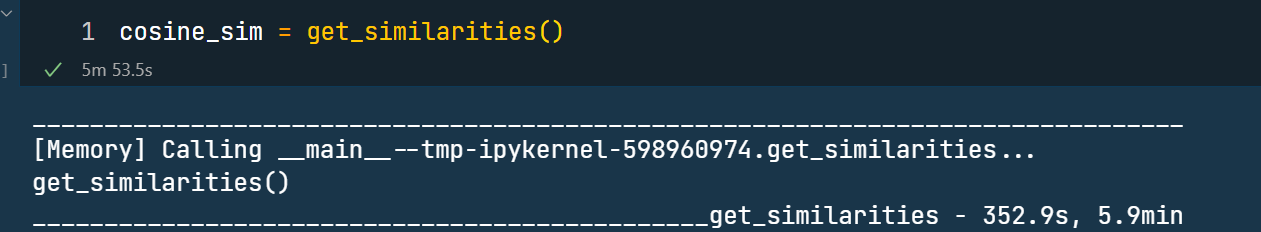

由于我们使用了 `joblib`缓存结果, 第二次加载这个矩阵只需要 3.3s 。

In [36]:
cosine_sim.shape, type(cosine_sim), cosine_sim.dtype

((10000, 10000), <class 'numpy.ndarray'>, dtype('float64'))

In [37]:
cosine_sim[:5, :5]


array([[1.        , 0.29042362, 0.27409518, 0.29692921, 0.34769348],
       [0.29042362, 1.        , 0.29676954, 0.2805517 , 0.23722667],
       [0.27409518, 0.29676954, 1.        , 0.39591191, 0.32875298],
       [0.29692921, 0.2805517 , 0.39591191, 1.        , 0.30646964],
       [0.34769348, 0.23722667, 0.32875298, 0.30646964, 1.        ]])

值得注意的是，`cosine_similarity`和`cosine_distances`有所不同，这两个加在一起是1，不要搞混了。

### “推理”协同过滤模型

按照协同过滤算法本身来说，现在我们本来只需要对测试集的每一个评分开始预测就行了，对测试集有评分的每一个用户和每一个电影，按照公式去计算训练集中相似的用户的评分的加权平均数就可以了。

但是我们可以把思路理地更清晰一些，实际上训练集确定的情况下，整个训练集的矩阵每一行是什么情况都是可以计算的，未来测试集只需要查询对应的结果即可，我们按照机器学习的术语，把这个过程称为“推理”（而刚才计算相似度矩阵的过程可以称为“训练”），得到的结果是新的 10000 x 10000的矩阵，每一行的评分是通过原始矩阵其他行的打分加权平均计算得到的。

如此一来，我们的操作是向量化的。

首先，根据我上面提到的“第二点”，我们需要排除用户自身和自身的相似度，不能用用户自身的评分来预测。实际上，更加合理的做法是计算平均数的时候排除评分为0的情况。

我们可以使用 np.nanmean() 来在忽略缺失值的情况下计算平均值。


In [38]:
example_array = np.array([np.nan, np.nan, 1])
np.nanmean(example_array) # 正确的结果是 1.0，错误的结果是 1/3

1.0

In [39]:
# 如果是加权平均数，也是同理
example_weights = [1, 2, 3]
mask = np.isnan(example_array)
weights = np.where(mask, np.nan, example_weights)
weighted_sum = np.nansum(example_array * weights)
weight_sum = np.nansum(weights)
weighted_mean = weighted_sum / weight_sum
weighted_mean # 应当仍是1 , 而不是 0.5

1.0

理论清晰了，刚才我们已经知道怎么对向量做操作，现在我们可以编写代码来排除没有评分的列的情况下求加权平均数，对整个矩阵去做操作。

In [40]:
X_train_dense = X_train_dense.astype(np.float64)

In [ ]:
#| exports
from copy import deepcopy
from tqdm import tqdm

In [42]:
# 评分范围是 1-5, 所以0就是缺失值，刚才稀疏矩阵的默认设为了0，我们需要nan
X_train_dense_nan = deepcopy(X_train_dense)
X_train_dense_nan[X_train_dense_nan==0] = np.nan
X_train_dense_nan[0]

array([nan, nan, nan, ..., nan, nan, nan])

In [43]:
np.ones((2, 3)).sum(axis=0)

array([2., 2., 2.])

In [44]:
#| exports

def compute_weighted_sum_on_matrix(cosine_sim, X_train_dense_nan):
# 创建一个与 X_train_dense 相同大小的矩阵，用于存储加权平均数
    X_train_weighted = np.zeros_like(X_train_dense_nan)

    # 遍历 X_train_dense 的每一行
    for i in tqdm(range(X_train_dense_nan.shape[0])):
        # 获取第 i 行的权重
        weights = cosine_sim[i, :]
        
        # 复制这个权重到整个矩阵的维度，方便后面掩码操作
        weights = np.repeat(weights, X_train_dense_nan.shape[1]).reshape(X_train_dense_nan.shape[0], X_train_dense_nan.shape[1])
        
        
        # 创建一个掩码，是 nan的就是True
        mask = np.isnan(X_train_dense_nan)
        
        
        # 将权重中的对应位置设置为 np.nan
        weights = np.where(mask, np.nan, weights)
        
        # 计算加权平均数，忽略 np.nan 值
        X_train_weighted[i, :] = np.nansum(X_train_dense_nan * weights, axis=0) / np.nansum(weights, axis=0)

    # X_train_weighted 现在是一个 mxn 的矩阵，其中每一行是忽略 np.nan 的加权平均数
    return X_train_weighted

@joblib_memory.cache
def get_X_train_weighted():
    return compute_weighted_sum_on_matrix(cosine_sim, X_train_dense_nan)

In [45]:
# X_train_weighted = get_X_train_weighted()

可以看到速度非常慢，不可接受（4分钟连第一个计算也没有完成），我们需要进行一些优化。
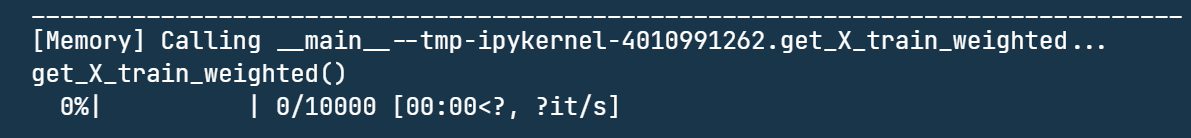

#### 速度优化——矩阵乘法

如果我们不考虑加权平均数需要忽略没有评分的其他用户这一问题，直接把0当做是有效的评分，并且基于相似度直接计算加权平均数，那么我们马上就发现其实矩阵乘法
cosine_sim @ X_train_dense 是有意义的，这就等价于每一行的 cosine_sim 线性组合 X_train_densede 所有行向量。这个离加权平均数只差了一个归一化的步骤，新的矩阵的每一行需要 除以 cosine_sim 那一行的和。

In [46]:
weight_sum = cosine_sim.sum(axis=1) # 每一行的和
weight_sum.shape

(10000,)

In [47]:
X_train_pred_wrong = (cosine_sim @ X_train_dense) / weight_sum[:, np.newaxis] # 升维变成一列向量，这样才能每一行去除这个值而不是每一列去除。
X_train_pred_wrong.shape

(10000, 10000)

In [48]:
X_train_pred_wrong[0]


array([0.0410934 , 0.00174947, 0.10677668, ..., 0.00775722, 0.01182744,
       0.02292204])

当然上面得到的结果是错误的，我们看到里面的值都是“0.0410934”之类的，明显小于1，不可能是实际的评分取值，这就是因为没有考虑到刚才我们说的排除没有和商品交互的用户提供的0评分的问题。

我们仔细观察上面的公式，可以发现 cosine_sim @ X_train_dense 其实计算的是正确的，因为评分为0的时候自然不会算进去，问题出在`/ weight_sum[:, np.newaxis]` 这一步把评分为0的用户也算了进去。

因此，正确的解决办法是，对每一个用户和每一个物品，都有不同的 weight_sum。
给定一个用户的时候，确定了和其他用户的相似性，但是不同物品有不同的nan mask，从而weight的加和有所不同。

我们经过一段时间的思考，可以注意到，这其实也是可以通过一个矩阵乘法来解决的。首先我们定义`mask`矩阵，如果是0（缺失评分）mask就是1，否则就是0。我们注意到`(1-mask)`矩阵，如果当做是一行列向量，那么每一个列向量就表示了物品对用户的选择，也就是这个物品有哪些用户是有评分的。使用这个列向量去对`cosine_sim`进行线性组合，其含义就是在进行一个选择性求和，只有非nan的地方才会相加。

In [49]:
mask = np.isnan(X_train_dense_nan)
weight_sum_correct = cosine_sim@(1-mask)
weight_sum_correct.shape

(10000, 10000)

In [50]:
X_train_pred = (cosine_sim @ X_train_dense) / weight_sum_correct
X_train_pred.shape

(10000, 10000)

最终我们的公式非常的简洁 `(cosine_sim @ X_train_dense) / (cosine_sim @ (X_train_dense!=0))`, 其中 @ 表示矩阵乘法， / 表示逐元素相除。

In [51]:
X_train_pred[0]


array([3.57833886, 1.76862034, 3.38810491, ..., 2.66767709, 1.94945024,
       2.63015681])

可以看到这一次我们得到的数值是正确的，是1-5的评分能得到的平均数。
网络上很多协同过滤的博客参差不齐，都没有提到这个公式，都是用for去写的，而《深度学习推荐系统》一书也没有涉及到这个细节。这里我们自己通过数学推导，终于得到了正确而高效的计算公式。

刚才我们是用稠密矩阵来实现对应的公式的，由于矩阵乘法已经被numpy库深度优化，所以我们的计算很高效。下面我们尝试稀疏矩阵实现同样的计算。
```python
cosine_sim_sparse = csr_matrix(cosine_sim)
not_zero_rating = csr_matrix(1-mask) # 实际上这个很稀疏，很多元素都是0
X_train_pred_sparse = (cosine_sim_sparse @ X_train) / (cosine_sim_sparse @ not_zero_rating)
X_train_pred_sparse.shape
np.allclose(X_train_pred, X_train_pred_sparse.toarray())
```

可以发现稀疏矩阵的速度在这个数据规模上和这个问题上，比稠密矩阵的还要慢不少，无法在合理的时间内完成。
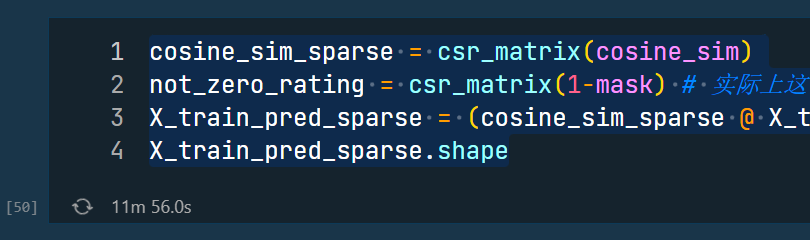

这可能是因为我们得到的最终结果是稠密的，经过矩阵乘法之后稀疏矩阵就不再稀疏，因而算法并不高效，需要算出10000*10000个点，还不如稠密矩阵表示。

### 评价协同过滤模型

现在我们有了 X_train_pred, 包括了对所有用户在所有物品上的评分，接下来只需要与 X_test 对比就可以了。

但是需要注意的是，X_test 并没有包含所有用户在所有物品上的评分，如果直接对这两个矩阵展开为向量去做RMSE，得到的结果当然是错误的。因为这样错误地把0评分和预测评分去做比较。

我们可以for遍历所有的测试数据，然后去查询 X_train_pred 中对应的评分，然后再去计算指标。我们也可以对矩阵去进行操作。

In [52]:
test_mask = (X_test_dense!=0)  # 获得一个 mask，在老师给的文档中也称为“指示矩阵”
masked_X_train_pred = test_mask * X_train_pred # 把 X_test_dense 没有评分的地方的 X_train_pred 也变成0 （这里通过乘法，乘1乘0实现，也可以通过赋值实现）
n = test_mask.sum() # 计算有评分的数量
rmse = np.sqrt(((X_test_dense-masked_X_train_pred)**2).sum() / n) # 计算 RMSE，因为没有评分的地方大家都是0，所以计算出来是对的。
rmse, n

(1.0183690394072489, 1719466)

我们也可以使用 PyTorch 来计算 RMSE，做出一个loss function。

In [ ]:
#| exports
import torch

In [54]:
#| exports
def ensure_tensor(x:np.ndarray|list, device:str="cuda:2"):
    # 确保输入loss函数的数据是张量
    return torch.tensor(x).to(device)
def masked_rmse_loss(reconstructed:torch.Tensor, matrix:torch.Tensor, verbose:bool=False, do_ensure_tensor:bool=True)->torch.Tensor:
    # 首先确保类型是tensor，而且device想同，这样才能在GPU上算Loss
    if do_ensure_tensor:
        reconstructed = ensure_tensor(reconstructed)
        matrix = ensure_tensor(matrix)
    # 获得一个 mask，在老师给的文档中也称为“指示矩阵”
    test_mask = (matrix!= 0)
    n = test_mask.sum()
    if verbose:
        print(f"Number of non-zero elements in the matrix: {n}")
    # 只对mask后的元素做Loss计算
    masked_matrix = matrix[test_mask]
    masked_reconstructed = reconstructed[test_mask]
    return torch.sqrt(torch.mean((masked_reconstructed - masked_matrix)**2))

In [55]:
masked_rmse_loss(ensure_tensor(X_train_pred), ensure_tensor(X_test_dense), verbose=True)

/tmp/ipykernel_1705708/3678547022.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).to(device)


Wed 2024-11-27 18:38:57.454612

INFO     Number of non-zero elements in the matrix: 1719466                                           ]8;id=124771;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=143256;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

tensor(1.0184, device='cuda:2', dtype=torch.float64)

刚才我们算出了在测试集上的RMSE，同理，其实我们也可以计算在训练集上的RMSE，这应该并不是0，因为协同过滤算法不仅考虑了原本用户自己的评分，还把相似用户的评分考虑进来了。

In [56]:
masked_rmse_loss(ensure_tensor(X_train_pred), ensure_tensor(X_train_dense), verbose=True)

/tmp/ipykernel_1705708/3678547022.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).to(device)


Wed 2024-11-27 18:39:01.089009

INFO     Number of non-zero elements in the matrix: 6897746                                           ]8;id=638104;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=740898;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

tensor(1.0127, device='cuda:2', dtype=torch.float64)

可以看出对于UserCF算法，训练集和测试集的RMSE误差差不多，训练集稍微低一些。

## 3. 基于梯度下降的矩阵分解算法实现

我们首先复习一下吴老师课程讲解的内容。

老师课上强调，矩阵分解可以把PCA、SVD、LDA三个重要的方法统一起来。

我们可以使用 PyTorch 来实现梯度下降矩阵分解，但是这里我们同时也尝试一下 jax 来实现。因为 jax 是 谷歌提出的新一代框架，结合了 NumPy 的接口和自动微分功能，以及强大的编译优化，据一些研究指出具有较好的性能。
```python
pip install -U "jax[cuda12]"
pip install flax
pip install treescope
```

### 模型定义

首先我们需要定义我们的模型，具体来说需要定义模型的参数 U和V。U和V建模了评分矩阵。

In [57]:
# 定义分解矩阵的大小
k = 50  # 隐向量维度
m, n = X_train_torch.shape

In [58]:
#| exports
import torch
import torch.nn as nn
import torch.optim as optim

为了让代码规范一些，我们把参数写为 module 形式。

In [59]:
#| exports
class MatrixFactorization(nn.Module):
    def __init__(self, n_users:int, n_items:int, # 定义分解矩阵的大小
                 k # 隐向量维度
                 ):
        super().__init__()
        self.U = nn.Parameter(torch.randn(n_users, k))
        self.V = nn.Parameter(torch.randn(n_items, k))
    
    def forward(self):
        return torch.matmul(self.U, self.V.t())

In [60]:
model = MatrixFactorization(m, n, k)
model().shape

torch.Size([10000, 10000])

我们再用 jax/flax 框架来尝试一下。

In [61]:
#| exports
# 再尝试一下jax
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap # 这三个函数在 jax 中叫做 "transformations", 意思是对函数进行操作的函数（也可以说是泛函、算子），这三个函数分别作用是  求导，即时编译，向量化。
import jax.random as jrandom # 为了和 torch.random 做区分，我们导入叫做 jrandom

In [62]:
# jax不需要 requires_grad 因为求导的逻辑不一样，jax待会会直接定义导函数。
# 在 jax 当中随机数非常重要。 jax的函数是纯函数，不能有副作用，而且输入相同时输出必须相同。所以随机数必须通过显式地传入随机种子，来让随机函数是纯函数。
key = jrandom.PRNGKey(42)
jU = jrandom.normal(key, (m, k))
jV = jrandom.normal(key, (n, k))

2024-11-27 18:39:11.782934: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:3: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Wed 2024-11-27 18:39:12.592821

INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute      ]8;id=253070;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=979326;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/jax/_src/xla_bridge.py#906\906]8;;\
         'GpuAllocatorConfig'                                                                                      

Wed 2024-11-27 18:39:12.620062

INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so:       ]8;id=611698;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=560761;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/jax/_src/xla_bridge.py#906\906]8;;\
         cannot open shared object file: No such file or directory                                                 

我们可以直接使用jax对 `jU` 和 `jV` 去做梯度下降，但是我们写得更加规范一些，现在我们使用`flax`框架把矩阵分解也写为一个Module。

注意，根据 https://github.com/google/flax , flax 有两套不同的API，一套是 `from flax import linen`, 一套是 `from flax import nnx`。
> Released in 2024, Flax NNX is a new simplified Flax API that is designed to make it easier to create, inspect, debug, and analyze neural networks in JAX. Flax NNX evolved from the Flax Linen API, which was released in 2020 by engineers and researchers at Google Brain in close collaboration with the JAX team.

后者与PyTorch更加接近，是flax的最新设计，我们决定使用后者。


In [63]:
#| exports
from flax import linen as jnn # 为了和 torch.nn 做区分，我们导入叫做 jnn，和flax官方的写法不同
from flax import nnx # 导入 nnx 库，里面包含了一些常用的网络层
from fastcore.all import store_attr # 导入 fastcore 基础库的 store_attr 函数，用来方便地存储类的属性，这样Python面向对象写起来不那么冗长。 请 pip install fastcore。
import treescope # flax 的 可视化

In [ ]:
# 定义 MatrixFactorization 模型
# 注意 flax 使用了 Python标准库 `dataclasses`， 因为面向对象的定义风格更加简洁，使用类变量specify了init的参数。
class JaxMatrixFactorization(nnx.Module):
    def __init__(self, n_users:int, n_items:int, # 定义分解矩阵的大小
                 k:int, # 隐向量维度
                 *, rngs: nnx.Rngs # 在 jax 中随机种子非常重要。
                 ):
        super().__init__()
        # store_attr()
        key = rngs.params()
        self.U = nnx.Param(jrandom.normal(key, (n_users, k)))
        self.V = nnx.Param(jrandom.normal(key, (n_items, k)))
        # 如果我们还有子模块，flax要求把 rngs 传递下去。
    def __call__(self):
        # return jnp.dot(self.U, self.V.T) # 不能使用这个，因为 nnx.Param 和 jnp.array 不一样，会导致 jax 编译错误，这个是jax的bug。
        return self.U @ self.V.T

In [65]:
# 现在我们可以构建这个模型
rngs=nnx.Rngs(params=42)
jmodel = JaxMatrixFactorization(m, n, k, rngs=rngs)
print(jmodel().shape)
nnx.display(jmodel)

Wed 2024-11-27 18:39:18.599747

INFO     (10000, 10000)                                                                               ]8;id=238578;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=633656;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

可见目前来看新版的 `nnx` 接口与PyTorch基本一样，只不过强调随机数种子的传递。旧版的`linen`则是有较大的不同，它并不能在类中储存状态，需要递归地从模型中调用初始化函数整合出一个大的参数向量出来。

### 损失函数定义

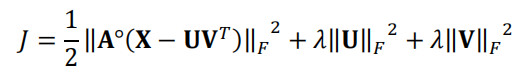

注意在 PyTorch 的设计哲学中，正则化项是通过优化器`weight_decay`选项来实现的，而不是在损失函数中计算。
这是因为损失函数通常输入是 (y_pred, y_true) 的形式，不包含模型参数，这样才能把逻辑解耦开来。所以如果我们在loss就实现 l2 regularization，是很麻烦而且没有必要的。而优化器对模型的参数有完全的访问权，可以精确控制哪些部分的参数使用什么学习率和什么正则化。

所以我们下面损失函数暂时忽略 $\lambda$ ，稍后会加入回来。

In [66]:
#| exports
# 定义PyTorch的损失函数
def masked_mse_loss(reconstructed:torch.Tensor, matrix:torch.Tensor)->torch.Tensor:
    observed_indices = torch.where(matrix != 0) # A 矩阵，表示哪里是有评分的，只在有评分的地方算loss。
    return 0.5*torch.mean((reconstructed[observed_indices] - matrix[observed_indices])**2)

# 同理，定义 jax 损失函数
def jax_masked_mse_loss(reconstructed:jnp.ndarray, matrix:jnp.ndarray)->jnp.ndarray:
    observed_indices = jnp.where(matrix != 0) # A 矩阵，表示哪里是有评分的，只在有评分的地方算loss。
    return 0.5*jnp.mean((reconstructed[observed_indices] - matrix[observed_indices])**2)

In [67]:
# 测试一下我们刚写的函数
masked_mse_loss(model(), model()) # 应当是0

tensor(0., grad_fn=<MulBackward0>)

In [68]:
jax_masked_mse_loss(jmodel(), jmodel()) # 应当是0

Array(0., dtype=float32)

可以看到 jax 和 torch 基本都是遵循numpy接口的，所以写法基本一样。由于PyTorch的求导方式是动态构建计算图，所以我们在上面的输出可以看到 tensor 带有一个 grad_fn 属性，用来记录计算图，而 jax 的输出则没有。

### 3.a 梯度下降训练分解矩阵U和V (k=50, λ=0.01)

In [ ]:
# 参考推荐系统库 https://surprise.readthedocs.io/en/stable/matrix_factorization.html 的默认参数设置，
# lmd = 2e-2
lr = 5e-3

# 参考老师给的设置
lmd = 0.01
k = 50

# 收敛条件
max_epochs = 100000
# required_rmse = 1.0
# required_delta_loss = 1e-4
required_delta_loss = 1e-6

#### PyTorch 实现训练矩阵分解模型

In [115]:
#| exports
import lightning as L # PyTorch Lightning库，这里我们只是用它来固定随机数种子

In [120]:
#| exports
def train_matrix_factorization(X_train_dense:np.array, X_test_dense:np.array, k:int = 50, 
                    lmd:float = 2e-2, lr:float = 5e-3, max_epochs:int = 100000, 
                    required_delta_loss:float = 1e-2,
                    random_state=42, device = 'cuda:4'):
    # 设置 PyTorch 随机种子，防止结果不一致。
    L.seed_everything(random_state) 
    # 输入数据转为 PyTorch 张量
    X_train_torch = torch.from_numpy(X_train_dense).to(device)
    X_test_torch = torch.from_numpy(X_test_dense).to(device)
    # 模型定义
    m, n = X_train_torch.shape
    model = MatrixFactorization(m, n, k).to(device)
    model = torch.compile(model)
    # 优化器定义
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=lmd)
    # 指标
    metrics = []
    # 优化循环
    bar = tqdm(range(max_epochs))
    previous_loss = 0
    for epoch in bar:
        optimizer.zero_grad()
        pred_matrix = model()
        loss = masked_mse_loss(pred_matrix, X_train_torch)
        loss.backward()
        optimizer.step()
        # 计算指标
        with torch.no_grad():
            # RMSE
            train_rmse = masked_rmse_loss(pred_matrix, X_train_torch, do_ensure_tensor=False)
            test_rmse = masked_rmse_loss(pred_matrix, X_test_torch, do_ensure_tensor=False)
            # loss 变化
            loss_item = loss.item()
            delta_loss = abs(loss_item - previous_loss)
            previous_loss = loss_item
            
            metric = dict(
                loss=loss_item,
                train_rmse = train_rmse.item(),
                test_rmse = test_rmse.item(), 
                delta_loss = delta_loss
            )
            # 指标记录
            metrics.append(metric)
            bar.set_postfix(**metric)
            # 中止条件
            if delta_loss<required_delta_loss:
                break
            
    return model, metrics

In [121]:
model, metrics = train_matrix_factorization(X_train_dense, X_test_dense, k=k, lmd=lmd, lr=lr, max_epochs=max_epochs, required_delta_loss=required_delta_loss)

INFO: Seed set to 42


Wed 2024-11-27 19:00:35.276313

INFO     Seed set to 42                                                                                  ]8;id=288389;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=256787;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#57\57]8;;\

  9%|▉         | 8898/100000 [05:29<56:16, 26.98it/s, delta_loss=9.99e-7, loss=0.229, test_rmse=0.944, train_rmse=0.676]  


In [122]:
metrics_df = pd.DataFrame(metrics)
metrics_df

loss  train_rmse  test_rmse    delta_loss
0     31.268773    7.908068   7.916553  3.126877e+01
1     30.852997    7.855316   7.867649  4.157756e-01
2     30.443528    7.803016   7.819154  4.094697e-01
3     30.040385    7.751179   7.771080  4.031427e-01
4     29.643580    7.699816   7.723437  3.968044e-01
...         ...         ...        ...           ...
8894   0.228510    0.676033   0.944070  1.001718e-06
8895   0.228509    0.676031   0.944089  1.001671e-06
8896   0.228508    0.676030   0.944108  1.000704e-06
8897   0.228507    0.676028   0.944127  1.000480e-06
8898   0.228506    0.676027   0.944146  9.992896e-07

[8899 rows x 4 columns]

#### Jax/Flax 实现训练矩阵分解模型

In [ ]:
from functools import partial
import optax

In [ ]:
# 训练函数
# @nnx.jit  # nnx 提供的 算子，进行自动状态管理
@partial(nnx.jit, static_argnums=(3, ))  # 静态参数，用于固定模型和优化器参数, 这个是为了解决一些不能被 jit 但是可以hash的参数，这里不能这样解决。参考 https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError
def train_step(jmodel:JaxMatrixFactorization, joptimizer:nnx.Optimizer, X_train_jnp:jnp.ndarray, criterion=jax_masked_mse_loss):
    def loss_fn(jmodel:JaxMatrixFactorization):
        pred_matrix = jmodel()
        return criterion(pred_matrix, X_train_jnp)
    loss, grads = nnx.value_and_grad(loss_fn)(jmodel) # 这是另一个nnx算子，自动求导函数、
    joptimizer.update(grads)  # In place 的更新操作，更新优化器参数和模型参数。
    return loss

In [ ]:
# 构建jax的优化器
joptimizer = nnx.Optimizer(jmodel, optax.adamw(lr))
X_train_jnp = jnp.array(X_train_dense) # 从numpy array 转换为 jax array
try:
    loss = train_step(jmodel, joptimizer, X_train_jnp)  
except Exception as e:
    print(e)

Wed 2024-11-27 19:06:14.722929

INFO     Abstract tracer value encountered where concrete value is expected: traced array with shape  ]8;id=288389;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=256787;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\
         int32[]                                                                                                   
         The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX               
         transformations.                                                                                          
         The error occurred while tracing the function train_step at                                               
         /tmp/ipykernel_1705708/2484339058.py:5 for jit. This concrete value was not available in                  
         Python because it depends on the value of the argument X_train_jnp.                                       
                                                                                                                   
         See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError                   

这是 jax jit编译时会遇到的典型问题，问题的根源在于我们刚才定义 `jax_masked_mse_loss` 函数的时候，使用到了 `jnp.where` 函数（使用到 `jnp.nonzero`函数），这个函数如果输入并不知道 size，就无法进行编译。

我们现在来改进一下这个函数。刚才 where 是选择了 indices 出来，所以导致了计算具有动态性，不利于jax的静态编译，我们可以使用另一种计算方式。

In [ ]:
@jit
def compilable_jax_masked_mse_loss(reconstructed:jnp.ndarray, matrix:jnp.ndarray)->jnp.ndarray:
    mask = (matrix!=0)  # 获得一个 mask，在老师给的文档中也称为“指示矩阵”
    masked_reconstructed = mask * reconstructed # 把 matrix 没有评分的地方的 reconstructed 也变成0 （这里通过乘法，乘1乘0实现，也可以通过赋值实现）
    n = mask.sum() # 计算有评分的数量
    rmse = jnp.sqrt(((matrix-masked_reconstructed)**2).sum() / n) # 计算 RMSE，因为没有评分的地方大家都是0，所以计算出来是对的。
    return rmse

(Array(0., dtype=float32), 0.0)

In [ ]:
loss = compilable_jax_masked_mse_loss(jmodel(), jmodel())
loss, float(loss) # 单个scalar转化为float

使用 jit 算子对 compilable_jax_masked_mse_loss 操作，然后计算一次，可以看到计算成功了，这个函数是可以被jax编译的。

现在我们可以来优化了。

In [ ]:
#| exports
import optuna

In [ ]:
# @jit
def train_matrix_factorization_jax(X_train_dense:np.array, X_test_dense:np.array, k:int = 50, 
                    lmd:float = 2e-2, lr:float = 5e-3, max_epochs:int = 100000, required_delta_loss:float = 1e-3,
                    random_state=42,
                    trial:optuna.Trial=None, critical_metric="test_rmse" # 用于下一章节的调优的 Pruning 
                    ):
    X_train_jnp = jnp.array(X_train_dense) # 从numpy array 转换为 jax array
    X_test_jnp = jnp.array(X_test_dense) # 从numpy array 转换为 jax array
    # 模型定义
    m, n = X_train_jnp.shape
    rngs=nnx.Rngs(params=random_state)
    jmodel = JaxMatrixFactorization(m, n, k, rngs=rngs)
    # 优化器
    joptimizer = nnx.Optimizer(jmodel, optax.adamw(learning_rate=lr, weight_decay=lmd))
    jmetrics = [] # 指标
    bar = tqdm(range(max_epochs))
    previous_loss:float = 0.0
    for epoch in bar:
        pred_matrix = jmodel()
        loss = train_step(jmodel, joptimizer, X_train_jnp, criterion=compilable_jax_masked_mse_loss)
        
        # 指标记录
        train_rmse = jnp.sqrt(loss)
        test_rmse = jnp.sqrt(compilable_jax_masked_mse_loss(pred_matrix, X_test_jnp))
        # 有关收敛
        loss_item = float(loss) # 把单个 scalar 转化为 float， 但是需要注意这个会让jit无法在外层编译
        delta_loss:float = abs(loss_item - previous_loss)
        previous_loss = loss_item
        
        metric = dict(
            loss = loss_item,  
            train_rmse = float(train_rmse),
            test_rmse = float(test_rmse), 
            delta_loss = delta_loss
        )
        # 指标的记录
        jmetrics.append(metric)
        bar.set_postfix(**metric)
        # optuna调参记录
        if trial is not None:
            for k, v in metric.items():
                trial.set_user_attr(k, v)
            trial.report(metric[critical_metric], step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        # 收敛条件
        if delta_loss<required_delta_loss:
            break
    return jmodel, jmetrics

In [127]:
# 设置 jax 计算的设备
jax.default_device = jax.devices("gpu")[1]
jax.default_device

CudaDevice(id=1)

In [128]:
jmodel, jmetrics = train_matrix_factorization_jax(X_train_dense, X_test_dense, k=k, lmd=lmd, lr=lr, max_epochs=max_epochs, required_delta_loss=required_delta_loss)

  6%|▌         | 5503/100000 [01:27<25:04, 62.82it/s, delta_loss=8.34e-7, loss=0.676, test_rmse=0.978, train_rmse=0.822]  


In [157]:
jmetrics_df = pd.DataFrame(jmetrics)
jmetrics_df

loss  train_rmse  test_rmse    delta_loss
0     7.955531    2.820555   2.821863  7.955531e+00
1     7.902468    2.811133   2.813115  5.306339e-02
2     7.849845    2.801758   2.804412  5.262232e-02
3     7.797671    2.792431   2.795755  5.217409e-02
4     7.745949    2.783154   2.787145  5.172205e-02
...        ...         ...        ...           ...
5499  0.675748    0.822039   0.978253  1.251698e-06
5500  0.675747    0.822038   0.978269  1.370907e-06
5501  0.675746    0.822038   0.978279  1.192093e-06
5502  0.675745    0.822037   0.978296  1.072884e-06
5503  0.675744    0.822036   0.978304  8.344650e-07

[5504 rows x 4 columns]

我们很明显看到 jax 的矩阵分解优化速度比PyTorch要快很多。不仅收敛的epochs数少了一半，而且每一个epoch需要的训练时间也更少。

- 为什么收敛的epochs数少了呢？可以看到是因为 jax 的初始值就更好一些。尽管 [jax.random.normal](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.normal.html) 与 [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html) 确实是等价的，而且 随机种子都是42，但是jax得到的初始UV确实更好。

- 为什么 jax 比 PyTorch 快呢？我们的 PyTorch 已经是使用了良好的代码实践，使用了 PyTorch 2.0 的 `torch.compile`功能，并且在不需要求导的情况下使用了 `torch.no_grad()`，然而仍然是打不过 jax。有人说这是因为 jax 支持 JIT，这确实没错，XLA技术具有强大的性能，但是 PyTorch 的 `torch.compile` 也未尝不利。参考[文章](https://zhuanlan.zhihu.com/p/660342914)，实际上问题的关键在于 JAX 强调 函数式编程和无状态设计，所有的函数都是纯函数，没有副作用，因此编译优化更简单，而 PyTorch 则是面向对象编程，有状态的设计，因而需要更多的编译优化。

为了确定文档中说的 `jax.random.normal` 与 `torch.randn` 等价，这里我们可以使用 KS 拟合优度假设检验，验证这两个方法得到的随机数是否来自于同一个分布。


In [134]:
from scipy.stats import kstest, norm

In [139]:
# 生成 PyTorch 随机数
L.seed_everything(42)
torch_samples = torch.randn(1000)
# 生成 JAX 随机数
jax_samples = jax.random.normal(jrandom.PRNGKey(42), (1000,))
res_torch = kstest(torch_samples, norm.cdf, alternative='two-sided')
res_jax = kstest(jax_samples, norm.cdf, alternative='two-sided')
res_mutual = kstest(jax_samples, torch_samples, alternative='two-sided')
if res_torch.pvalue > 0.05:
    print(f"无法拒绝零假设，所以我们得接受torch就是服从标准正态分布")
if res_jax.pvalue > 0.05:
    print(f"无法拒绝零假设，所以我们得接受jax就是服从标准正态分布")
if res_jax.pvalue > 0.05:
    print(f"无法拒绝零假设，所以我们得接受这两个分布是一样的。")
res_torch, res_jax, res_mutual

INFO: Seed set to 42


Wed 2024-11-27 19:42:05.180708

INFO     Seed set to 42                                                                                  ]8;id=529903;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=631262;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#57\57]8;;\

Wed 2024-11-27 19:42:05.233134

INFO     无法拒绝零假设，所以我们得接受torch就是服从标准正态分布                                      ]8;id=288389;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=256787;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Wed 2024-11-27 19:42:05.248983

INFO     无法拒绝零假设，所以我们得接受jax就是服从标准正态分布                                        ]8;id=709570;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=776646;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Wed 2024-11-27 19:42:05.257456

INFO     无法拒绝零假设，所以我们得接受这两个分布是一样的。                                           ]8;id=442417;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=33326;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\


(
    KstestResult(statistic=0.019189070906030226, pvalue=0.848033539038892, statistic_location=-0.38583097, statistic_sign=1),
    KstestResult(statistic=0.034437055011013185, pvalue=0.18222928193437893, statistic_location=-0.63853437, statistic_sign=1),
    KstestResult(statistic=0.041, pvalue=0.37012017606173, statistic_location=-0.81669724, statistic_sign=1)
)

我们可以看到统计上来说确实是等价的，但是得到的结果在相同随机数种子下确实是不同的数值。而且由于 res_torch 的 p值比 res_jax 的更高，我们可以认为 torch 的随机结果反而更加接近标准正态分布。

从 jax random模块的[文档](https://jax.readthedocs.io/en/latest/jax.random.html)来看，jax采用的随机数生成算法是"threefry2x32"，设计的目的是为了更好的并行化和向量化。

根据[这篇学术论文](https://arxiv.org/abs/2401.17345), NumPy, TensorFlow, 和 PyTorch 三个框架使用的随机数生成算法分别是 Mersenne Twister, PCG, and Philox。因此，PyTorch生成随机数的算法与Jax有所不同，这也就导致了我们刚才都选择了42作为随机种子，但是得到的UV矩阵初值有所不同，jax的随机矩阵在矩阵分解这个问题上似乎更好。

#### 画出迭代过程中目标函数值和测试集上 RMSE 的变化

我们这里尝试使用 plotly 而非 matplotlib 库来绘制图片，因为使用html或者jupyter notebook查看本文档的时候，plotly 能展示交互性的图表。
```bash
pip install plotly
```

In [154]:
#| exports
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

由于 目标函数值 （MSE）的量纲和 RMSE不同，我们可以使用高级的绘图技巧，在同一张图上使用不同的纵轴来绘制不同的曲线，以方便比较。参考[官方文档](https://plotly.com/python/multiple-axes/) 和 [中文翻译版本](https://daobook.github.io/plotly-book/tutorial/fundamentals/15_multiple-axes.html)。

In [174]:
#| exports
def draw_metrics_df(df:pd.DataFrame, title:str='Metrics'):
    # 使用 plotly 创建图表
    fig = go.Figure()
    # 需要支持第二纵轴
    fig = make_subplots(specs=[[{"secondary_y": True}]], figure=fig)

    # 绘制 loss 曲线
    fig.add_trace(go.Scatter(x=df.index, y=df['loss'], name='Loss', mode='lines'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df.index[1:], y=df['delta_loss'][1:], name='Delta Loss', mode='lines'), secondary_y=False)

    # 绘制 train_rmse 和 test_rmse 曲线
    fig.add_trace(go.Scatter(x=df.index, y=df['train_rmse'], name='Train RMSE', mode='lines'), secondary_y=True)
    fig.add_trace(go.Scatter(x=df.index, y=df['test_rmse'], name='Test RMSE', mode='lines'), secondary_y=True)
    
    # 更新坐标轴
    fig.update_yaxes(title_text="Loss", titlefont_color="red", tickfont_color="red", secondary_y=False)
    fig.update_yaxes(title_text="RMSE", titlefont_color="blue", tickfont_color="blue", secondary_y=True)
    
    # 标题
    fig.update_layout(title=dict(
        text=title
    ),)
    return fig

In [177]:
fig = draw_metrics_df(metrics_df, title="Metrics of PyTorch Based Matrix Factorization Training")
fig

In [178]:
fig = draw_metrics_df(jmetrics_df, title="Metrics of Jax Based Matrix Factorization Training")
fig

如图所示，Loss 和 Delta Loss 使用的是左侧的坐标轴，单位为评分的平方，而Train RMSE 和 Test RMSE 使用的是右侧的坐标轴，单位为评分。Delta Loss是用来决定收敛条件的，是Loss的差分的绝对值。

最终的PyTorch和Jax分别的测试集RMSE为

In [159]:
metrics[-1]['test_rmse'], jmetrics[-1]['test_rmse']

(0.9441459774971008, 0.9783037304878235)

我们对上面的图进行一些分析：

1. Loss和Train RMSE 的趋势是一致的，因为他们之间是平方关系；他们随着训练时间的增加而减小，一开始减小的速度比较快，后面变化趋于平缓。
2. Delta Loss 也随着时间逐渐减小。
3. Test RMSE 一开始先是快速降低，随后缓慢降低，最后反而开始上升。这就说明到了后期出现了过拟合现象，测试损失反而在上升。可以使用 Early Stop等方法缓解此问题。
4. Jax 和 PyTorch 的曲线趋势相似，但是初值不相同，这个问题我们已经在上文中详细讨论，这里不再赘述。

### 3.b 矩阵分解参数调优

#### 科学调参的原则与方法

我在以前的作业当中详细描述了谷歌AI团队《深度学习调优指南》的思想，涉及到的概念包括目标元参数、冗余元参数和固定元参数，贝叶斯优化、演化计算、近似随机搜索，科学实验的控制变量法与调参实验设计中的探索与利用等。这里我们不再赘述，需要的话可以阅读[这次作业的文档](https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data/blob/main/notebooks/coding_projects/P1_KNN/kd_tree.ipynb) 以及 谷歌[Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook)原文。

简单总结来说，调参的本质是进行科学实验，通过控制变量法，探究在冗余和固定元参数（a.k.a. 无关变量）搜索到最优或者保持固定时，目标元参数（a.k.a. 目标超参数、自变量）对因变量（a.k.a. 评价指标）的影响。

而对于调参实验的结果，我们可以使用我们这门课当中学习的假设检验方法，来探究目标元参数的取值（比如选择自己提出的方法还是其他人的方法）之间导致因变量的差异是否具有统计显著性，以及哪一个元参数的取值最好。这个可以参考我们[上一次作业ANOVA的文档](https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data/blob/main/notebooks/coding_projects/P1_ANOVA/anova.ipynb)，这里我们同样不再赘述。


#### 搜索空间定义

本次作业中，我们可以认为 k 的取值是 **目标元参数**，我们实验的目的就是探究 不同k的取值对于矩阵分解的效果有何影响。直观地来说，k越大，我们矩阵可以容纳的秩就越大，表达能力就更强，应当具有更好的分解效果，这是我们的实验假设。具体而言，k决定了模型参数的大小，而李航《统计学习方法》中介绍的泛化误差上界定理，[Open AI 对 LLM 探究的 Scaling Law](https://openai.com/index/scaling-laws-for-neural-language-models/) 都指出模型参数和模型的泛化误差具有重要的关系。我们通过本次调参实验可以尝试看看有无类似的规律。

而 $\lambda$ 以及 学习率 `lr` 的取值则是 **冗余元参数** 或者 **固定超参数**。由于作业要求我们搜索 $\lambda$，所以它是 冗余元参数，我们需要为每一个 k 的取值搜素它的值调到最优，而为了节省计算资源，`lr`则可以当做固定超参数。为了提高实验速度，我们把`required_delta_loss`设的比上一节要大一些，并且使用 jax 来做分解。

为了定义搜索空间，我们使用dataclass，要求传入函数的参数是强类型，而且有一个随机概率分布，这样方便定义调参。这里用到我自己写的`scholarly_infrastructure`库的一个核心功能`experiment_setting`，对Python标准的dataclass进行了改进。

In [190]:
#| exports
from scholarly_infrastructure.rv_args.nucleus import RandomVariable, experiment_setting
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from typing import Optional, Union
from dataclasses import asdict
import optuna

In [217]:
#| exports
@experiment_setting
class MatrixFactorizationSetting:
    # 隐因子数量 k
    k: int = ~RandomVariable( # ~ 表示 服从 这个分布，这是我写的库实现的语法糖
        default=20,
        description="Number of latent factors.",
        # distribution=IntDistribution(low=1, high=128, log=True) # 我们假设 k 和 RMSE满足某种“scaling law”，所以使用 log 分布。
        distribution=CategoricalDistribution([1, 4, 16, 64]) 
        )
    
    # 正则化参数 λ
    lmd: float = ~RandomVariable(
        default=0.001,
        description="Regularization parameter.",
        distribution=FloatDistribution(0.001, 0.1, log=True)
    )
    
    # 学习率
    lr: float = ~RandomVariable(
        default = 5e-3, 
        description="Learning rate.",
        distribution=FloatDistribution(1e-4, 1e-1, log=True) # 虽然本次我们实验不调，但是其固有分布也是要写清楚的，下次实验或许要调。
    )
    
    # 精度要求
    required_delta_loss: float = ~RandomVariable(
        default = 1e-3, 
        description="Required Delta Loss, a.k.a. tolerance",
        distribution=FloatDistribution(1e-8, 1e-1, log=True)
    )      

In [218]:
# 可以展示文档， MatrixFactorizationSetting 是一个 dataclass，也是一个 experiment_setting
MatrixFactorizationSetting.show_dataframe_doc()[:1]

name           type  default  \
0    k  <class 'int'>     20.0   

                                     default_factory  init  repr  hash  \
0  <dataclasses._MISSING_TYPE object at 0x7ef6e43...  True  True  None   

   compare metadata                                            kw_only  \
0     True     None  <dataclasses._MISSING_TYPE object at 0x7ef6e43...   

                 description                                     distribution  
0  Number of latent factors.  CategoricalDistribution(choices=(1, 4, 16, 64))

固定元参数定义

In [230]:
#| exports
fixed_meta_params = MatrixFactorizationSetting(lr=5e-3, # surprise库的值
                                               required_delta_loss=1e-4)
frozen_rvs = {"lr", "required_delta_loss"}

#### 定义目标函数

由于我们数据不是很多，我们直接就使用 测试集作为验证集，允许使用验证集来进行模型选择（包括调参、Early Stopping等）。

In [231]:
#| exports
def objective(trial:optuna.Trial, critical_metric="test_rmse"):
    # experiment_setting 类具有 optuna_suggest 方法，可以自动推荐一个设置出来。
    config:MatrixFactorizationSetting = MatrixFactorizationSetting.optuna_suggest(
        trial, fixed_meta_params, frozen_rvs=frozen_rvs)
    # 调用上面写好的 train_matrix_factorization_jax 函数
    jmodel, jmetrics = train_matrix_factorization_jax(X_train_dense, X_test_dense, 
                                              trial=trial, critical_metric=critical_metric, # 为了进行搜索剪枝，传入这两个参数
                                              **asdict(config))
    # 假如采取最后的
    # best_metric = jmetrics[-1][critical_metric]
    # 假如允许 Early Stop
    best_metric = min(map(lambda m: m[critical_metric], jmetrics))
    return best_metric

#### 执行调参搜索

In [232]:
#| exports
from thu_big_data_ml.help import runs_path
from optuna.samplers import *
from optuna.pruners import *
import json

In [233]:
#| exports
study_path = runs_path / "optuna_studies.db"
sqlite_url = f"sqlite:///{study_path}"

In [ ]:
#| exports
study = optuna.create_study(
    study_name="matrix factorization hpo 11.27 4.0", # 3.0 使用 1e-3
    storage=sqlite_url, 
    load_if_exists=True, 
    # sampler=QMCSampler(seed=42), # 谷歌建议
    sampler=TPESampler(seed=42), # 谷歌建议
    pruner=HyperbandPruner(), # 通过中间结果来决定是否停止搜索
    direction="minimize")
study.set_user_attr("contributors", ["Ye Canming"])
study.set_user_attr("fixed_meta_parameters", json.dumps(asdict(fixed_meta_params)))

[I 2024-11-27 21:57:31,990] A new study created in RDB with name: matrix factorization hpo 11.27 4.0


接下来运行

In [ ]:
#| eval: false
study.optimize(objective, n_trials=10)

In [ ]:
#| eval: false
study.optimize(objective, n_trials=30)

In [ ]:
#| eval: false
study.optimize(objective, n_trials=20)

#### 分析实验结果

首先加载调参实验的结果，实验分析的时候，不用重新再跑一次实验，这两个是分开的

In [ ]:
study = optuna.load_study(
    study_name="matrix factorization hpo 11.27 4.0", 
    storage=sqlite_url)

##### 最好的参数组合是哪个？

In [242]:
study.best_value, study.best_params

(0.9159189462661743, {'k': 16, 'lmd': 0.07791470666172784})

##### Optuna 可视化分析结果
可以通过下面的命令对我们刚才保存调参结果的数据库文件进行可视化展示：
```bash
optuna-dashboard sqlite:///optuna_studies.db --port 18081
```
<img src=image.png width=30% />


In [247]:
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_optimization_history

In [249]:
plot_optimization_history(study)

我们进行了60次实验，随着实验的进行，目标函数越来越好。注意有很多实验因为被提前剪枝了所以没有在图中显示出来，这些实验的目标函数值太大了，不会优于显示在图中的实验。

In [ ]:
plot_intermediate_values(study)

图中我们可以看出，不同的实验的loss下降曲线是有所不同，有的曲线是向上凸的。

In [ ]:
plot_param_importances(study)

从这个图我们可以发现，相比于正则化项 lambda的取值，k的取值明显对泛化性能更加重要。

##### 以 k 为目标元参数进行假设检验分析——期望改进分析

期望改进分析是说如果有多个方法可以选择的时候，我提出的方法随机地应用于某一个人使用的元参数组合时，我的方法的期望性能相比于采纳其他方法，是否显著地更好。

In [ ]:
# 首先我们拿到实验的所有数据
df = study.trials_dataframe()
df.head()

number     value             datetime_start          datetime_complete  \
0       0  0.961816 2024-11-27 21:57:37.217204 2024-11-27 21:58:54.987898   
1       1  0.919173 2024-11-27 21:58:55.112755 2024-11-27 22:01:19.734468   
2       2  1.117243 2024-11-27 22:01:20.259350 2024-11-27 22:01:49.182465   
3       3  0.920926 2024-11-27 22:01:49.277027 2024-11-27 22:04:11.261289   
4       4  1.533228 2024-11-27 22:04:17.347049 2024-11-27 22:04:40.633025   

                duration  params_k  params_lmd  user_attrs_delta_loss  \
0 0 days 00:01:17.770694         4    0.002051               0.000100   
1 0 days 00:02:24.621713        16    0.026070               0.000100   
2 0 days 00:00:28.923115         4    0.002310               0.007060   
3 0 days 00:02:21.984262        16    0.003823               0.000100   
4 0 days 00:00:23.285976         1    0.008168               0.013748   

   user_attrs_loss  user_attrs_test_rmse  user_attrs_train_rmse  \
0         0.916142              0.961816               0.957153   
1         0.805639              0.919173               0.897574   
2         1.239060              1.117243               1.113131   
3         0.809304              0.920926               0.899613   
4         2.349351              1.533228               1.532759   

   system_attrs_completed_rung_0  system_attrs_completed_rung_1  \
0                            NaN                            NaN   
1                       2.309793                       2.299495   
2                       2.021852                       2.018061   
3                       2.299917                       2.270888   
4                       1.921702                       1.920640   

   system_attrs_completed_rung_2  system_attrs_completed_rung_3  \
0                            NaN                            NaN   
1                       2.269680                       2.190724   
2                       2.007246                       1.979886   
3                       2.193796                       2.017946   
4                       1.917642                       1.910277   

   system_attrs_completed_rung_4  system_attrs_completed_rung_5  \
0                            NaN                            NaN   
1                       2.011784                       1.097557   
2                       1.928901                       1.117243   
3                       1.108612                       0.929011   
4                       1.898259                       1.533228   

   system_attrs_completed_rung_6     state  
0                            NaN  COMPLETE  
1                       0.927841  COMPLETE  
2                            NaN    PRUNED  
3                            NaN  COMPLETE  
4                            NaN    PRUNED

In [ ]:
# 用于后续指定列进行分析
target = "value" # 实际上是 test_rmse
treatment = "params_k"

In [271]:
# 只需要分析表格中我们感兴趣的列
intersted_cols = [c for c in df.columns if c.startswith("params") or "user_attrs" in c or c=="value"]
dfi = df[intersted_cols].dropna(subset=[target])
dfi[treatment] = dfi[treatment].astype("int")
dfi.head()

value  params_k  params_lmd  user_attrs_delta_loss  user_attrs_loss  \
0  0.961816         4    0.002051               0.000100         0.916142   
1  0.919173        16    0.026070               0.000100         0.805639   
2  1.117243         4    0.002310               0.007060         1.239060   
3  0.920926        16    0.003823               0.000100         0.809304   
4  1.533228         1    0.008168               0.013748         2.349351   

   user_attrs_test_rmse  user_attrs_train_rmse  
0              0.961816               0.957153  
1              0.919173               0.897574  
2              1.117243               1.113131  
3              0.920926               0.899613  
4              1.533228               1.532759

In [259]:
import seaborn as sns

<Axes: xlabel='params_k', ylabel='value'>

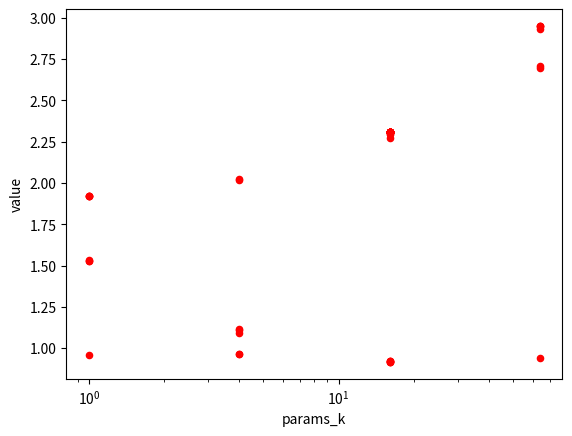

In [274]:
#| fig-cap: "不同k的RMSE箱线图对比"
#| fig-alt: "每一个红点是一次实验结果。"
fig, ax = plt.subplots()
ax.set_xscale('log')
# sns.boxplot(data=dfi, x=treatment, y=target, ax=ax)
dfi.plot(x=treatment, y=target, ax=ax, kind='scatter', c='red')

<Axes: title={'center': 'value'}, xlabel='params_k'>

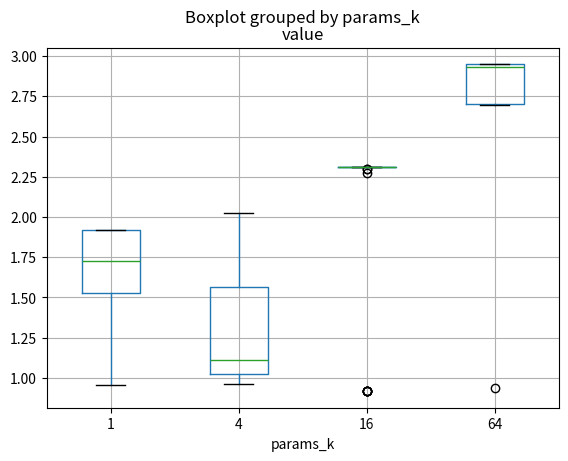

In [276]:
dfi.boxplot(by=treatment, column=target)

我们首先画出了散点图和箱线图，可以直观感觉到，k小的时候，test_rmse的上界反而更小，而平均值则是在k=4时取最好。

现在我们来画经验分布图，包括没有分组前和分组之后的数据的分布图。

Text(0.5, 9.444444444444438, 'test_rmse')

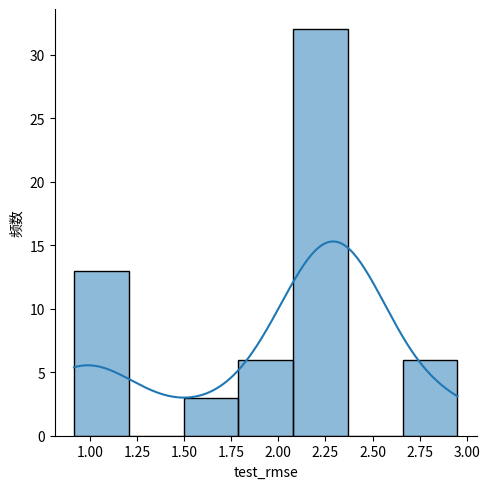

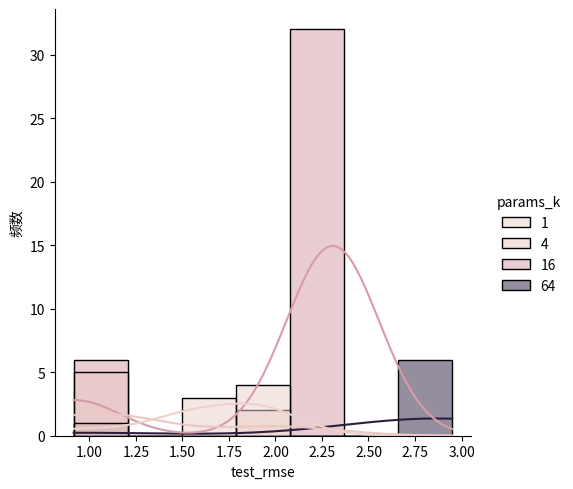

In [279]:
sns.displot(data=dfi, x=target, kde=True, kind="hist")
plt.ylabel("频数")
plt.xlabel("test_rmse")
sns.displot(data=dfi, x=target, hue=treatment, kde=True, kind="hist")
plt.ylabel("频数")
plt.xlabel("test_rmse")

刚才进行了可视化分析，现在进行严格的假设检验。

我们在同时比较多个方法，可以用上一次作业的ANOVA检验吗？
由于我们使用了nbdev系统，我上次写作业的代码已经变成了成熟的python模块，我们可以直接调用我之前写的代码，看看ANOVA的条件是否满足。
由于上次写的`test_normality_group`需要大量数据才有效，我们需要换别的假设检验。

In [288]:
#| exports
from thu_big_data_ml.big_data_analytics.anova import test_normality_group, homogeneity_of_variance
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
from thu_big_data_ml.big_data_analytics.anova import auto_anova_for_df, auto_kruskal_for_df

In [ ]:
#| exports
# 根据上次我们ANOVA作业调研的结果， Shapiro-Wilk 和 Lilliefors 是适合小样本情况下的正态检验方法。
def test_normality_small_sample(df, interesting_col, hue_col='群类别', transform=None):
    if transform is None:
        transform = lambda x: x
    grouped_data = df.groupby(hue_col)
    normality_results = {}
    for name, group in grouped_data:
        normality_result = {}
        data_column = group[interesting_col].to_numpy()
        data_column = transform(data_column)
        
        # Shapiro-Wilk test
        res = stats.shapiro(data_column)
        normality_result['Shapiro-Wilk'] = "Not Normal" if res.pvalue < 0.05 else "Normal"
        
        # Lilliefors test 
        res = lilliefors(data_column)
        normality_result['Lilliefors'] = "Not Normal" if res[1] < 0.05 else "Normal"
        
        normality_results[name] = normality_result
    return pd.DataFrame(normality_results)

In [287]:
test_normality_small_sample(dfi, interesting_col=target, hue_col=treatment)

1           4           16          64
Shapiro-Wilk  Not Normal  Not Normal  Not Normal  Not Normal
Lilliefors        Normal  Not Normal  Not Normal  Not Normal

In [282]:
homogeneity_of_variance(dfi, interesting_col=target, hue_col=treatment)

The variances are not homogeneous!



{
    'ratio_largest_to_smallest': 2.158185623471692,
    'bartlett_result': BartlettResult(statistic=3.6668498840499297, pvalue=0.29975821213270615)
}

对于正态性，k=1的时候根据Lilliefors检验，是正态分布，其他情况下拒绝了是正态分布的假设。
对于方差齐性，根据拇指法则，方差不齐，但是根据假设检验，方法齐性满足。

那么我们可以勉强使用。

In [289]:
auto_anova_for_df(dfi, interesting_col=target, hue_col=treatment)

Source  Sum of Squares (SS)  Degrees of Freedom (df)  Mean Square (MS)  \
0  Between             6.865326                        3          2.288442   
1   Within            15.207092                       56          0.271555   
2    Total            22.072418                       59               NaN   

         F         p   p_excel  
0  8.42717  0.000103  0.000103  
1      NaN       NaN       NaN  
2      NaN       NaN       NaN

尽管ANOVA的使用条件不满足，但是我们勉强使用ANOVA，可以看到ANOVA方法的p值很小，很显著地不同k之间存在显著差异！

接下来我们使用 Kruskal-Wallis 检验，这个检验不需要方差齐性和正态性满足，就可以对多列样本进行比较。

In [291]:
res = auto_kruskal_for_df(dfi, interesting_col=target, hue_col=treatment)
if res.pvalue < 0.05:
    print(f"There is a significant difference between the different {treatment}.")
res

Wed 2024-11-27 23:14:42.491233

INFO     There is a significant difference between the different params_k.                            ]8;id=665822;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=179451;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

KruskalResult(statistic=21.605648342166887, pvalue=7.879126651465415e-05)

Kruskal-Wallis H-test tests的零假设是 不同组的中位数之间没有显著差异。看来我们可以拒绝原假设，认为不同k的矩阵分解的RMSE的中位数有显著差异。

刚才我们检验出来存在显著差异，但是不知道具体是谁比谁大有显著性，所以我们还需要使用post-hoc类型的假设检验来进行进一步的分析。

首先刚才检验的是中位数有显著差异，我们来求一下分组的中位数。

In [300]:
# 分组中位数
medians = df.groupby(treatment)[target].median().sort_values(ascending=True)
order = medians.index[:] # 中位数的排序
medians


params_k
4     1.111837
1     1.726936
16    2.309724
64    2.931462
Name: value, dtype: float64

Dunn’s test就是针对 Kruskal-Wallis one-way analysis 对应的 post-hoc 检验方法（之一，还有其他的）。

In [294]:
#| exports
import scikit_posthocs as sp
from scikit_posthocs import posthoc_dunn

In [301]:
res = posthoc_dunn(dfi, val_col=target, group_col=treatment, 
             sort=True, p_adjust='holm')

# 按照中位数大小排序
res = res.reindex(order)
res = res[order]
res

4         1         16        64
params_k                                        
4         1.000000  0.835664  0.033024  0.000609
1         0.835664  1.000000  0.035515  0.000703
16        0.033024  0.035515  1.000000  0.035515
64        0.000609  0.000703  0.035515  1.000000

(<Axes: ylabel='params_k'>, <matplotlib.colorbar.Colorbar object at 0x7ef55c5e1b40>)

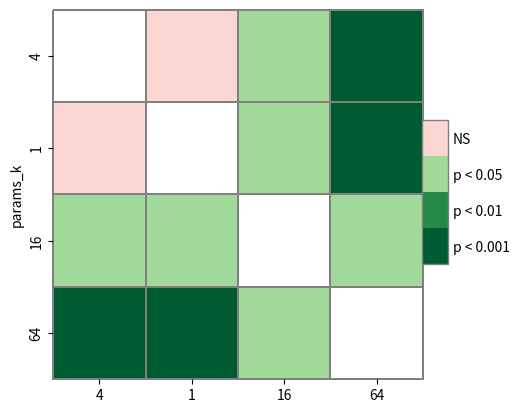

In [302]:
# 对 post hoc检验的结果进行热力图可视化
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(res, **heatmap_args)

从结果表可以看出，k=4和k=1的矩阵分解方法都非常显著地优于k=16和k=64的方法，是最好的两个参数。而k=16又显著地由于k=64的情况。而k=4和k=1之间，由于实验数据不足，无法得出明确的结论。

## 4. 基于用户的协同过滤方法与矩阵分解算法的结果与优缺点对比

### 理论上的优缺点对比

[《深度学习推荐系统》](https://yd.qq.com/web/reader/b7732f20813ab7c33g015deakaab325601eaab3238922e53)一书中对这两个方法都有所介绍，其中提到一些观点，这里我阅读总结如下，其中括号部分是我针对本次项目情况的思考和疑惑

基于用户的协同过滤方法(UserCF)的优缺点

1. 优点：符合人们直觉上的“兴趣相似的朋友喜欢的物品，我也喜欢”的思想。因为是基于用户的相似度来进行推荐。书上认为这个方法非常直观、可解释性很强。（本次Netflix数据集就是假设其他和我对电影评分相似的朋友评价过的电影如果我去看也会有相似的评分）
2. 缺点：用户相似度矩阵的存储开销非常大。在实际的互联网应用中，用户数远远大于物品数（？一定是这样吗，根据[分析报告](https://pdf.dfcfw.com/pdf/H3_AP202407261638343337_1.pdf), 淘宝用户数量是10亿，而2000万商家的商品数量是数十亿，不好说谁比谁多），为了快速找到最相似的n个用户，需要存储用户相似度矩阵（？真的是这样吗，KD树、FAISS等数据结构可以很高效地找到k近邻），因为用户数数以亿计，所以这个相似度矩阵很大，随着用户的增长以$n^2$的速度快速增长，系统难以承受。（本次数据集中，物品是电影，数量和用户一样多，相似度矩阵确实很大）
3. 缺点：新用户推荐问题。用户的历史数据向量是稀疏的，而对于一个只有几次购买记录的新用户来说，很难找到和他相似的用户。不只是新用户，如果正反馈获取是很困难的应用场景，比如酒店预订和大件商品预订，所有用户都很稀疏，互相之间的相似度都很低。
4. 优点：推荐具有社交属性，可以让用户快速得知兴趣相似的人喜欢什么，比较适合新闻推荐场景。因为不同人的新闻兴趣点比较分散，所以新闻的及时性和热点性比用户对新闻的兴趣偏好更重要（？所以这不就说明UserCF没有用吗，为什么王喆这里说userCF能发现和追踪热点呢）。
5. 缺点：对于兴趣变化稳定的应用不太适合。比如电商场景中，某段时间内用户会倾向于某一类热点商品，这个时候商品向量的相似度比用户向量的相似度是更加有价值的。（本次数据集NetFlix属于这个场景，因为看电影的评分是相对固定的偏好）
6. 缺点：泛化能力较差，因为无法把两个用户或者物品相似信息推广到其他用户和其他物品的相似上，导致新用户或者冷门物品太过稀疏，很少被推荐。
7. 缺点：只能利用共现矩阵也就是用户和物品的评分交互信息，无法有效引入用户年龄、性别，商品类别、描述等额外的信息，相比逻辑回归等机器学习模型而言使用的信息太少，所以泛化能力有限。（本次项目当中，Netflix数据集就包括了电影的标题信息，如果进行自然语言处理提取特征，可以提升推荐效果）

矩阵分解技术的优缺点

1. 优点：泛化能力相对协同过滤更好。使用稠密的隐向量来表示用户和物品，所以可以挖掘到用户的隐含兴趣和物品的潜在特征，可以弥补协同过滤处理稀疏矩阵能力不足的问题。
2. 缺点：和协同过滤的缺点7一样，也只是利用了共现矩阵的信息，没有利用到其他信息。
3. 缺点：王喆指出，k越大，隐向量的表达能力越强，但是容易过拟合，所以泛化能力会相应降低。所以工程中需要多次实验才能找到最优的k值。
4. 优点：相比协同过滤，空间复杂度低，因为不需要存储mxm的相似度矩阵，只需要存储用户和物品的隐向量。（本次项目中 MatrixFactorization model 的参数量确实是比协同过滤的小）
5. 优点：更好的扩展性和灵活性。矩阵分解的最终产出是用户和物品的隐向量矩阵，与深度学习中的Embedding思想不谋而合（真的一样吗），因此矩阵分解的结果也非常便于与其它特征进行组合和拼接，并便于与深度学习网络进行无缝结合。


### 实验结果比较

我们可以来看看实验结果是否支持上面的理论分析。

协同过滤方法我们得到的训练集RMSE是1.0127, 测试集RMSE是1.0184。

对于给定 k=50, λ=0.01 的情况下，使用lr=5e-3, required_delta_loss=1e-6，Pytorch和 jax 在训练集上的RMSE是分别是6.760268e-01和8.220364e-01, 测试集上的RMSE分别是 9.441460e-01和9.783037e-01，

在没有进行调参的情况下，矩阵分解的性能轻松超越了协同过滤方法，在训练集和测试集上都更小，**可见矩阵分解的表达能力和泛化能力都优于协同过滤，确实符合理论分析中所说，使用稠密的隐向量表示用户和物品是可以挖掘到用户的隐含兴趣和物品的潜在特征的，弥补了协同过滤能力不足的问题**。

在实现协同过滤的时候，我们确实进行了多次优化，才成功计算出最后的推荐值，而且整个系统中最慢的步骤和存储量最大的步骤就是求解相似度矩阵，即使使用了sklearn的方法进行了稀疏矩阵相似度的优化，还是耗费了十多分钟的时间，**相比矩阵分解实验所需要的时间长，存储量也大，符合理论分析中协同过滤的第二点和矩阵分解的第四点**。

In [240]:
metrics_df.iloc[-1], jmetrics_df.iloc[-1]


(
    loss          2.285061e-01
train_rmse    6.760268e-01
test_rmse     9.441460e-01
delta_loss    9.992896e-07
Name: 8898, dtype: float64,
    loss          6.757439e-01
train_rmse    8.220364e-01
test_rmse     9.783037e-01
delta_loss    8.344650e-07
Name: 5503, dtype: float64
)

而在lr=5e-3, required_delta_loss=1e-4条件下，搜索k和λ我们发现，λ对于RMSE的影响不大，而k的影响却很大。我们通过严格的假设检验分析，发现了k=1和k=4的矩阵分解方法显著优于k=16和k=64的矩阵分解方法，而k=16的矩阵分解方法又显著地优于k=64的矩阵分解方法。从平均值来看，k=4的RMSE比k=1的RMSE要小，但是缺乏统计学证据，差异并不显著。

由此**可以验证矩阵分解理论分析第三点**，即 k越大，隐向量的表达能力越强，但是容易过拟合，所以泛化能力会相应降低。所以k=4在我们这次实验中是折中的最优最优选择。可见，在实际工程应用中，需要调解k这个元参数是矩阵分解算法的一个缺点。我们使用optuna调参也消耗了大量的时间，即使使用了最先进的Tree Prazen优化方法和Hyperband剪枝方法。

刚才我们做的调参分析是期望改进分析，是说参数随机选取的情况下，哪个k期望的性能最好。如果参数不是随机选取，而是通过调参优化到最优呢？这也是一个公平比较各个方法的另外一个分析手段。我们列出下表：

In [ ]:
# 其他无关变量调到最优时，目标自变量对指标的影响。
best_rows = dfi.loc[dfi.groupby(treatment)[target].idxmin()]
best_rows[['params_k', 'user_attrs_test_rmse', 'user_attrs_train_rmse', 'user_attrs_delta_loss']]

params_k  user_attrs_test_rmse  user_attrs_train_rmse  \
7          1              0.958201               0.956666   
0          4              0.961816               0.957153   
15        16              0.915919               0.893912   
6         64              0.937775               0.851572   

    user_attrs_delta_loss  
7                  0.0001  
0                  0.0001  
15                 0.0001  
6                  0.0001

如上表所示，随着k的增大，train_rmse 会变小，所以说k越大，模型的表达能力越强。而对于test_rmse，在最优参数的情况下，k=16是最小的，而不是k=64最小。因而k=16在调参到最优的情况下，即具有k=1和k=4不具备的表达能力，也可以避免像k=64那样过拟合。

综上所述，我们的实验结果基本支持书上给出的分析，我们通过本次实验深入了解了两种方法的实现细节和性能差异，受益匪浅。

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()